# Deep Learning with Artificial Neural Networks (ANNs)

## Impact of Parameter Tuning for Insight into the Fundamental Architecture of ANNs

Thinkful Prompt:
 1. Preprocess your data so that you can feed it into ANN models.
 2. Split your data into training and test sets.
 3. Try different ANN models and train them on your training set. You can play with the following:
    1. Number of layers
    2. Activation functions of the layers
    3. Number of neurons in the layers
    4. Different batch sizes during training
 4. Compare your models' training scores and interpret your results.
 5. Evaluate how your models perform on your test set. Compare the results of your models.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# # import sys
# # sys.path.append('/content/drive/My Drive/Thinkful/30. Unsupervised Learning Capstone')
# import os
# os.chdir('/content/drive/My Drive/Thinkful/33. Deep Learning')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Python Libraries and Initialize Global Settings.

In [2]:
# Import Python libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from IPython.display import display, HTML
import warnings
import traceback
import random
import logging
import requests as req
import itertools


# Set global options in libraries and Python environment.
%matplotlib inline
# %matplotlib widget
warnings.filterwarnings('ignore')
pd.set_option('use_inf_as_na', True)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', 1000)  # Int or None.
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set(style="ticks", color_codes=True)
logging.basicConfig()   # log messages to stdout
logging.getLogger('sqlalchemy.dialects.postgresql').setLevel(logging.INFO)


from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import flatten

### Download and Preprocess fashion MNIST data set.

In [3]:
# Load fashion MNIST data set.
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Set variables.
x_len, y_len, z_len = X_train.shape
input_dim = y_len * z_len  # 28 * 28 = 784
output_dim = nb_classes = 10

# Reshape image data into two-dimensions.
X_train = X_train.reshape(60000, input_dim)
X_test = X_test.reshape(10000, input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# One-hot encode category target variables for machine-learning-capable data format.
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

### Run an Artificial Neural Network (ANN) Classifier.

In [4]:
"""
    Compile and Train an Artificial Neural Network (ANN).
    Usage:
        x_len, y_len, z_len = X_train.shape
        input_dim = y_len * z_len  # 28 * 28 = 784
        ANN_model, result_df = compile_and_train_ANN_classifier(
                                   X_train, Y_train, X_test, Y_test, input_dim, 
                                   neuron_counts=[32, 16, 10], activation='relu', 
                                   optimizer='sgd', loss='categorical_crossentropy', 
                                   metrics='accuracy', batch_size=32, epochs=20, verbose=0)
        display(result_df.head())
"""
def compile_and_train_ANN_classifier(X_train, Y_train, X_test, Y_test, input_shape, neuron_counts, 
                                     activation, optimizer, loss, metrics, batch_size, epochs, verbose):
    import time
    
    start = time.time()
    layer_count = len(neuron_counts)
    if not(isinstance(metrics, list)):
        metrics = [metrics]
    
    ANN_model = Sequential()
    
    for i in range(layer_count):
        if (i == 0):
            ANN_model.add(Dense(neuron_counts[i], activation=activation, input_shape=(input_shape,)))
        elif (i > 0) & (i < layer_count - 1):
            ANN_model.add(Dense(neuron_counts[i], activation=activation))
        elif (i == layer_count - 1):
            ANN_model.add(Dense(neuron_counts[i], activation='softmax'))
        else:
            raise IndexError('Artificial neural network build error based on neuron_counts.')
    
    ANN_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    ANN_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
    score_train = ANN_model.evaluate(X_train, Y_train, verbose=0)
    score = ANN_model.evaluate(X_test, Y_test, verbose=0)
    if verbose == 1:
        print('Test score: {:,.1f}%'.format(score[0] * 100))
        print('Test accuracy: {:,.1f}%'.format(score[1] * 100))
    
    total_neurons = sum(neuron_counts)
    execution_time = time.time() - start
    
    statistics_dict = {
        'test_score':     [score[0]],
        'test_accuracy':  [score[1]],
        'train_score':    [score_train[0]],
        'train_accuracy': [score_train[1]],
        'execution_time': [execution_time],
        'layer_count':    [layer_count],
        'total_neurons':  [total_neurons],
        'neuron_counts':  [neuron_counts],
        'activation':     [activation],
        'optimizer':      [optimizer],
        'loss':           [loss],
        'metrics':        [metrics],
        'batch_size':     [batch_size],
        'epochs':         [epochs]
    }
    result_df = pd.DataFrame.from_dict(statistics_dict)
    return ANN_model, result_df


"""
    Run n number of ANNs with random parameters to test for promising parameters.
"""
def run_ANN_random_parameter_tests(n, X_train, Y_train, X_test, Y_test, input_dim, epochs):
    neuron_counts_list = [  # Ending integer must match category count.
        # Testing effect of changing layer counts with flat neuron counts.
        [10, 10],
        [10, 10, 10],
        [10, 10, 10, 10],
        [10, 10, 10, 10, 10],
        # Testing effect of changing neuron counts with flat layer counts.
        [10, 10, 10, 10],
        [20, 20, 20, 10],
        [30, 30, 30, 10],
        [40, 40, 40, 10],
        # Testing effect of changing layer counts with decreasing funnel pattern of neuron counts.
        [20, 10],
        [30, 20, 10],
        [40, 30, 20, 10],
        [50, 40, 30, 20, 10]
    ]
    activation_list = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential']
    optimizer_list =  ['sgd', 'adagrad', 'adadelta', 'rmsprop', 'adam']
    loss_list =       ['categorical_crossentropy', 'binary_crossentropy', 'poisson', 'mean_squared_error',
                       'kullback_leibler_divergence']    # 'sparse_categorical_crossentropy', 
    batch_size_list = [16, 24, 32, 40, 64, 128, 256, 512]
    
    result_df_list =  []
    error_parameters = []
    
    parameter_inputs = list(itertools.product(
        neuron_counts_list, activation_list, optimizer_list, loss_list, batch_size_list))
    parameter_inputs_df = pd.DataFrame(parameter_inputs, 
                                       columns=['neuron_counts', 'activation', 'optimizer', 'loss', 'batch_size'])
    parameter_sample_df = parameter_inputs_df.sample(n=n, replace=False, random_state=432)    # frac=0.01, OR n=100,
    print("There are a total {:,.0f} possible combinations".format(len(parameter_inputs)),
          "of input parameters to sample from.",
          " Testing {:,.0f} combinations.".format(parameter_sample_df.shape[0]))
    
    total_param_sets = parameter_sample_df.shape[0]
    compl_param_sets = 0
    
    for parameter_test_set in parameter_sample_df.to_dict(orient='records'):
        try:
            ANN_model, result_df = compile_and_train_ANN_classifier(
                X_train, Y_train, X_test, Y_test, input_dim, parameter_test_set['neuron_counts'], 
                parameter_test_set['activation'], parameter_test_set['optimizer'], parameter_test_set['loss'], 
                metrics, parameter_test_set['batch_size'], epochs, verbose=0)
            result_df_list.append(result_df)
            compl_param_sets += 1
            print("\rCompleted {:,.1f}% : ".format(compl_param_sets/total_param_sets*100), 
                  parameter_test_set['neuron_counts'], parameter_test_set['optimizer'],
                  parameter_test_set['loss'], parameter_test_set['batch_size'], flush=True, end='\r')
        except:
            print("\rError with", parameter_test_set['neuron_counts'], parameter_test_set['optimizer'],
                  parameter_test_set['loss'], parameter_test_set['batch_size'], flush=True, end='\r')
            error_parameters.append(parameter_test_set)
            continue
    
    results_df = pd.concat(result_df_list, axis='index', ignore_index=False)\
        .sort_values(by=['train_accuracy'], ascending=False)
    
    return results_df


# results_df = run_ANN_random_parameter_tests(n=25, X_train, Y_train, X_test, Y_test, input_dim, epochs)
results_df = pd.read_csv('random_test_results.csv', index_col=0)
display(results_df.head(20))

,test_score,test_accuracy,layer_count,total_neurons,neuron_counts,optimizer,loss,metrics,batch_size,epochs
0,0.134,0.886,5,150,"[50, 40, 30, 20, 10]",adam,poisson,['accuracy'],128,20
0,0.062,0.883,4,100,"[40, 30, 20, 10]",adam,binary_crossentropy,['accuracy'],16,20
0,0.061,0.881,4,130,"[40, 40, 40, 10]",adam,binary_crossentropy,['accuracy'],256,20
0,0.018,0.880,4,100,"[40, 30, 20, 10]",adam,mean_squared_error,['accuracy'],24,20
0,0.018,0.880,4,100,"[30, 30, 30, 10]",rmsprop,mean_squared_error,['accuracy'],24,20
0,0.137,0.878,4,100,"[30, 30, 30, 10]",adam,poisson,['accuracy'],16,20
0,0.018,0.877,4,100,"[40, 30, 20, 10]",adam,mean_squared_error,['accuracy'],128,20
0,0.018,0.876,4,130,"[40, 40, 40, 10]",adam,mean_squared_error,['accuracy'],16,20
0,0.062,0.875,4,100,"[30, 30, 30, 10]",rmsprop,binary_crossentropy,['accuracy'],256,20
0,0.019,0.875,4,100,"[40, 30, 20, 10]",rmsprop,mean_squared_error,['accuracy'],16,20


In [5]:
# results_df.nlargest(n=1, columns=['test_accuracy']).iloc[row, :].to_dict()

# parameter_sample_df = parameter_inputs_df.sample(frac=0.01, replace=False, random_state=432)
# for row in range(parameter_sample_df.shape[0]):
#     print(parameter_sample_df.iloc[row, :].to_dict())

## Plot Parameter Testing Results Versus Accuracy Score

__Number of Layers:__ Each of the 3, 4, and 5 layers (including the final softmax layer) were able to acheive several accuracy scores above 0.85, and reviewing the maximum scores we see almost an entire point gain going from 3 to 4 layers while going to 5 layers only provides a dimished gain of one-third point.  The average score is highest using 5 layers, with 4 layers and 3 layers showing the second and third highest mean scores.  The layers should be __4, 5, or 6__.

__Average Neurons Per Layer:__ The highest top and mean accuracy scores were for models with an average neuron per layer between __25 and 30__.

__Total Count of Neurons:__ Obviously, no surprise here to see a clear trend of __increasing accuracy with increasing total neurons__ (following the complexity level of calculations but costing more time and/or hardware resources).

__Batch Size:__ The larger the batch size, the more efficient the model.  Without sactificing any significant accuracy, it seems that a larger batch size ranging from __64 to 256__ exhibits high accuracy scores.

__Optimizer:__ Clearly, __adam__ is the best optimizer and __rmsprop__ is the second best.

__Loss Function:__ It is evident that __categorical_crossentropy__ is the best loss function and __poisson__ is second best.


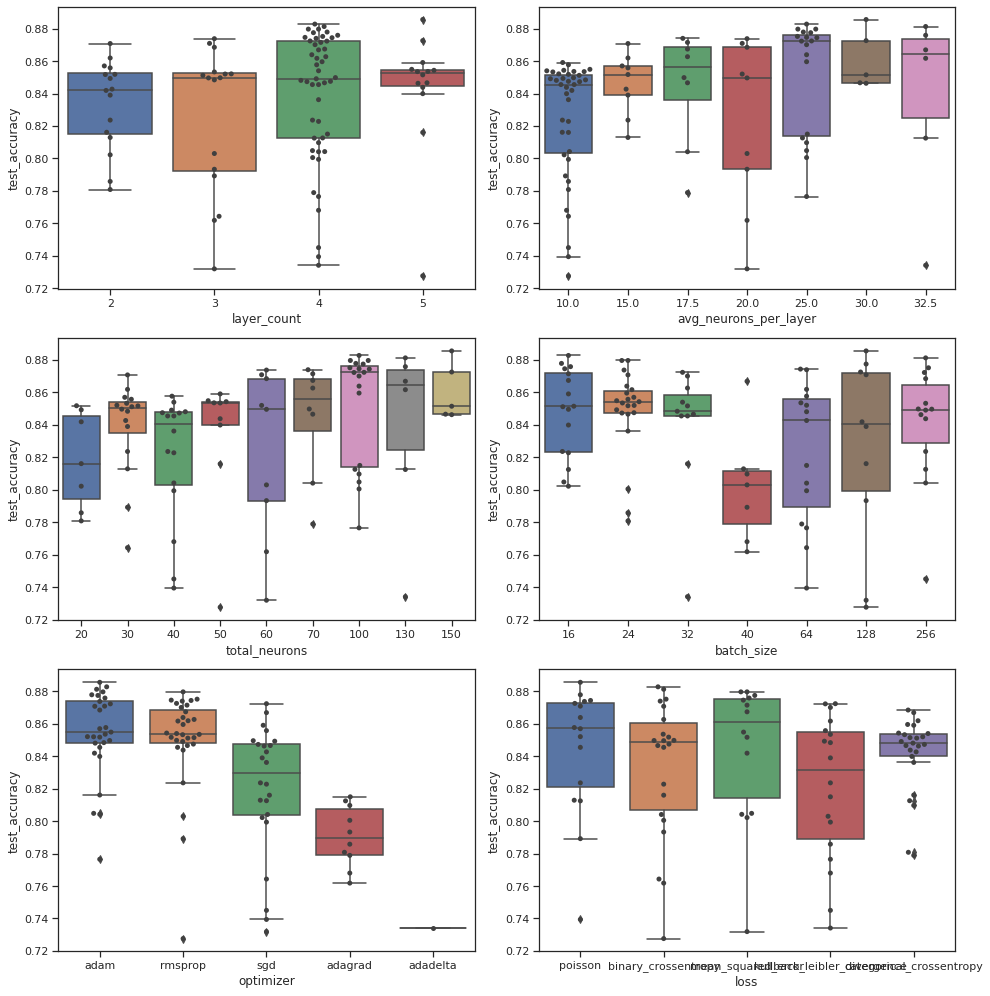

In [6]:
results_df['avg_neurons_per_layer'] = results_df['total_neurons'] / results_df['layer_count']
group_cols = ['layer_count', 'avg_neurons_per_layer', 'total_neurons', 'batch_size', 'optimizer', 'loss']
grouped_df = results_df.groupby(group_cols)['test_accuracy'].mean().to_frame()
results_df_mask = ( results_df['test_accuracy'] >= results_df['test_accuracy'].quantile(0.50) )

figr, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14), sharey=False, sharex=False)
count = 0
for col in group_cols:
    row_num = (count + 1) // 2 + (count + 1) % 2
    col_num = count % 2 + 1
    ax = sns.boxplot(x=col, y='test_accuracy', data=results_df[results_df_mask], 
                     ax=axs[row_num - 1, col_num - 1]) # orient='h', 
    ax = sns.swarmplot(x=col, y='test_accuracy', data=results_df[results_df_mask], color='.25', 
                       ax=axs[row_num - 1, col_num - 1])
    count += 1

plt.tight_layout()
plt.show()

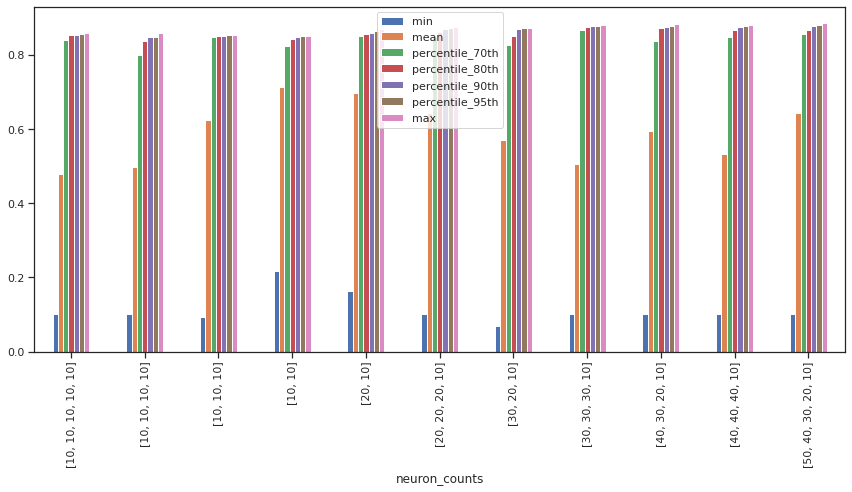

,min,mean,percentile_70th,percentile_80th,percentile_90th,percentile_95th,max
neuron_counts,,,,,,,
"[10, 10, 10, 10, 10]",0.100,0.478,0.841,0.854,0.854,0.855,0.859
"[10, 10, 10, 10]",0.100,0.497,0.799,0.836,0.848,0.849,0.858
"[10, 10, 10]",0.094,0.625,0.849,0.851,0.852,0.853,0.853
"[10, 10]",0.218,0.712,0.824,0.843,0.850,0.851,0.852
"[20, 10]",0.163,0.698,0.850,0.856,0.860,0.865,0.871
"[20, 20, 20, 10]",0.100,0.644,0.848,0.863,0.869,0.872,0.874
"[30, 20, 10]",0.068,0.570,0.826,0.852,0.870,0.872,0.874
"[30, 30, 30, 10]",0.100,0.504,0.867,0.874,0.877,0.879,0.880
"[40, 30, 20, 10]",0.100,0.594,0.837,0.872,0.876,0.879,0.883


In [7]:
layer_counts_df = results_df.groupby(['neuron_counts'])['test_accuracy'].agg(
    ['min', 'mean', lambda x: x.quantile(0.70), lambda x: x.quantile(0.80), 
     lambda x: x.quantile(0.90), lambda x: x.quantile(0.95), 'max']).rename(
    columns={'<lambda_0>': 'percentile_70th', '<lambda_1>': 'percentile_80th',
             '<lambda_2>': 'percentile_90th', '<lambda_3>': 'percentile_95th'})
layer_counts_df.plot(kind='bar', figsize=(12, 7))
plt.tight_layout()
plt.show()
display(layer_counts_df)

## Run optimized parameters for ANN and check scores.

THe optimized model is showing a low test/train loss score and high accuracy on both the test (88.2%) and training data (92.2%).  I selected model parameters based on minimizing the loss score on the training and test sets.  If the accuracy is extremely high on the training set, then that could be overfitting if there no corrsponding and similar accuracy in the test set.  This approach does not appear to be overfitting, but could use some normalization applications.

In [8]:
ANN_model, result_df = compile_and_train_ANN_classifier(
                           X_train, Y_train, X_test, Y_test, input_dim, 
                           neuron_counts=[50, 40, 30, 20, 10], activation='selu', 
                           optimizer='adam', loss='poisson', 
                           metrics='accuracy', batch_size=32, epochs=20, verbose=0)
display(result_df.head())

,test_score,test_accuracy,train_score,train_accuracy,execution_time,layer_count,total_neurons,neuron_counts,activation,optimizer,loss,metrics,batch_size,epochs
0,0.136,0.879,0.120,0.925,57.793,5,150,"[50, 40, 30, 20, 10]",selu,adam,poisson,[accuracy],32,20
